In [2]:
import fiona
import osmnx as ox
import shapely
import math
import pyproj
import sys

import numpy as np
import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd

from matplotlib import pyplot
from functools import partial
from shapely import geometry
from shapely.ops import transform
from descartes import PolygonPatch
from matplotlib.patches import Arc
from shapely.geometry import Point, Polygon, MultiPolygon
%matplotlib inline

### CUSTOM CLASSES
sys.path.append('../../../alg')
import distance_buffer as db
import border_generators as bg
import marching_army as ma

In [3]:
reload(bg)

<module 'border_generators' from '../../../alg/border_generators.pyc'>

In [4]:
reload(db)

<module 'distance_buffer' from '../../../alg/distance_buffer.pyc'>

In [28]:
reload(ma)

<module 'marching_army' from '../../../alg/marching_army.py'>

# Intelligent Shifting / Rotating
- want to intelligently shift (U/D/L/R) in combo w/ rotating (CW/CCW) to get the best coverage with the lowest amount of circles
- **NOTE: INTELLIGENT S/R SHOULD BE APPLIED AFTER THE POPULATION CENTERS ARE TAKEN INTO ACCOUNT (BC IT WILL CHANGE OUTCOME)**

In [6]:
##############################################

### Get the place and show it 

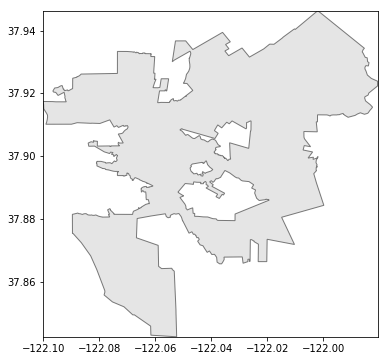

In [7]:
gdf, placegeom = bg.getplace('Walnut Creek, California, USA')
# plot the city
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in placegeom:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [8]:
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),pyproj.Proj(init='epsg:3857'))
transgeom = transform(proj, placegeom)
transgeom = transgeom[0]

In [9]:
print type(transgeom.exterior)

<class 'shapely.geometry.polygon.LinearRing'>


In [10]:
from shapely.geometry import LineString

In [15]:
bounds = transgeom.bounds
start_line, pt1,pt2 = ma.gen_starting_line(bounds)
print bounds
print start_line
print pt1,pt2

intpt = ma.intersect_line_region(pt1, start_line, transgeom.exterior)
print intpt

randpts = ma.gen_rand_pt_on_line(pt1, pt2, start_line, transgeom)
#print randpts



(-13592126.456990628, 4557195.678592932, -13578819.013366627, 4571847.8160177665)
[-0.72104506  0.69288818]
[-13584693.7428067    4564604.93117385] [-13591431.25676542   4571079.34451987]
LINESTRING (-13589291.2178522 4569022.874346203, -13582585.13010002 4562578.660010125)


In [29]:

%%time
candptsalltry1, borderpts = ma.gen_cand_pts(transgeom, start_line, randpts, 100.0)


CPU times: user 1min 37s, sys: 1.31 s, total: 1min 38s
Wall time: 1min 40s


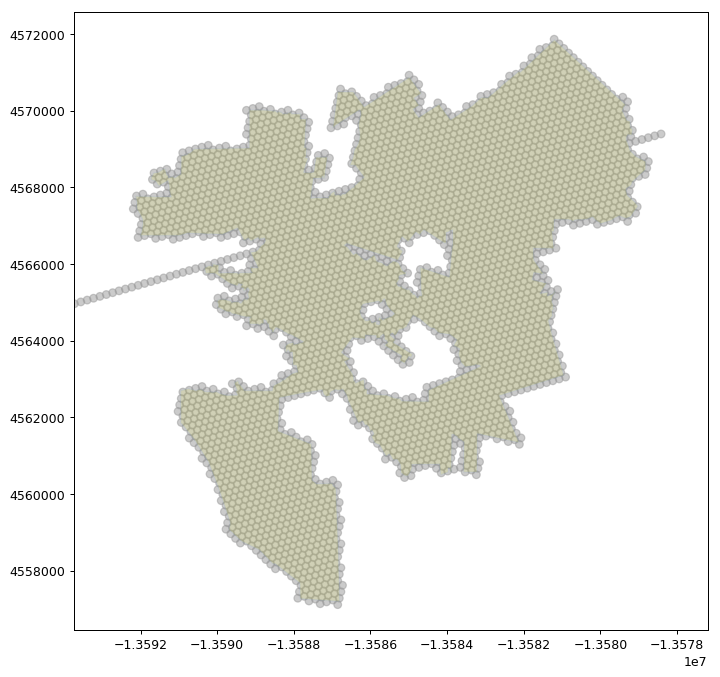

In [30]:
ax1, fig1 = db.plot_fig(transgeom)
#db.plot_line(ax, intpt.coords,ls='-',color='red',zorder=2)

for i in range(0, len(candptsalltry1)):
    db.plot_radii(ax1, candptsalltry1[i], 100.0, alpha=0.5)
    
for i in range(0, len(borderpts)):
    db.plot_radii(ax1, borderpts[i], 100.0, alpha=0.5, color="pink")
#ax.plot(candptsalltry1[9][0][0], candptsalltry1[9][0][1], 'o', color='green', alpha=0.5)
#ax.plot(candptsalltry1[0][0][0], candptsalltry1[0][0][1], 'o', color='purple', alpha=0.5)

pyplot.show()